Using sheet: Heart_disease
Shape: (908, 13)

Head:
   age   sex               cp  trestbps  chol    fbs         restecg  thalch  \
0   63  Male   typical angina       145   233   True  lv hypertrophy     150   
1   41  Male  atypical angina       135   203  False          normal     132   
2   57  Male     asymptomatic       140   192  False          normal     148   
3   52  Male   typical angina       118   186  False  lv hypertrophy     190   
4   57  Male     asymptomatic       110   201  False          normal     126   

   exang  oldpeak        slope          thal  num  
0  False      2.3  downsloping  fixed defect    0  
1  False      0.0         flat  fixed defect    0  
2  False      0.4         flat  fixed defect    0  
3  False      0.0         flat  fixed defect    0  
4   True      1.5         flat  fixed defect    0  

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 908 entries, 0 to 907
Data columns (total 13 columns):
 #   Column    Non-Null Count  Dtype  
---  

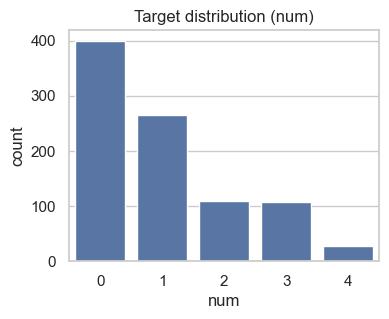

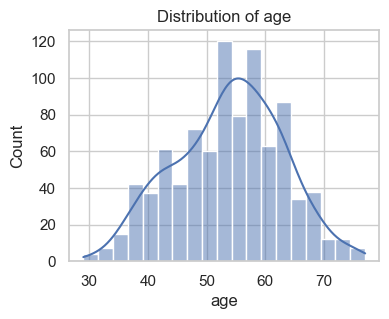

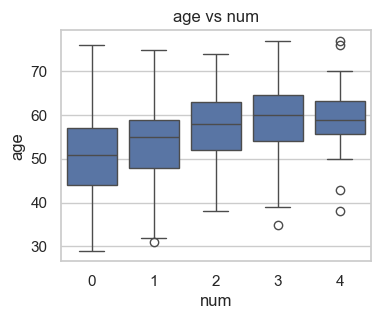

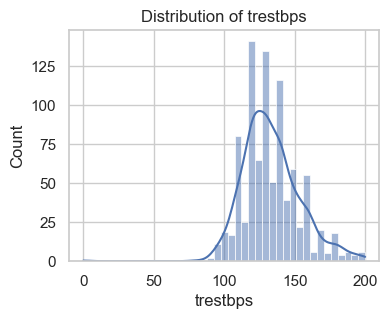

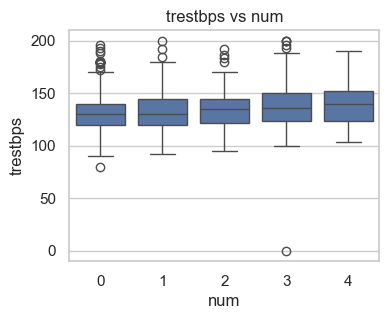

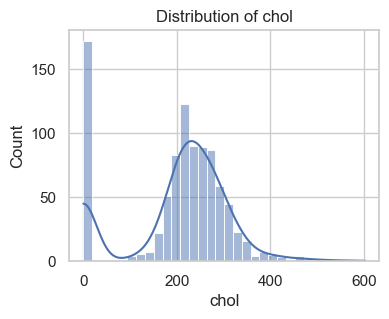

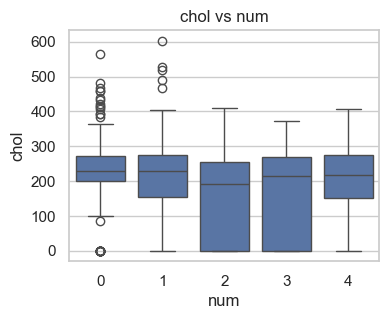

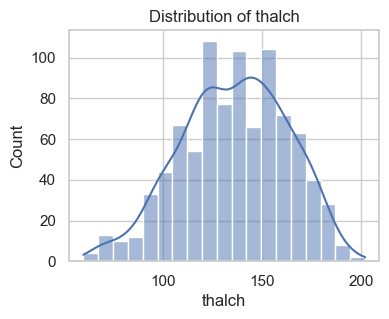

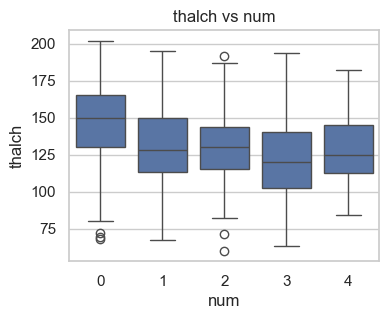

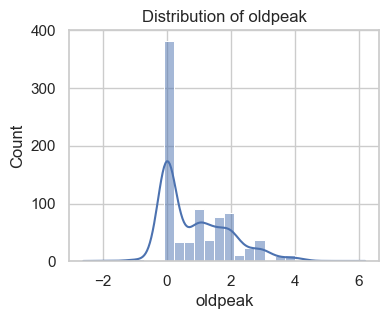

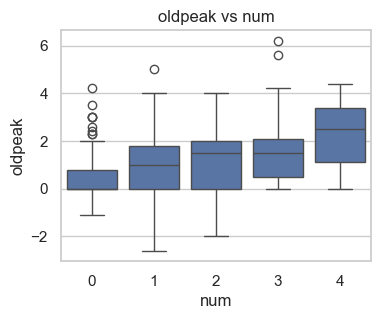

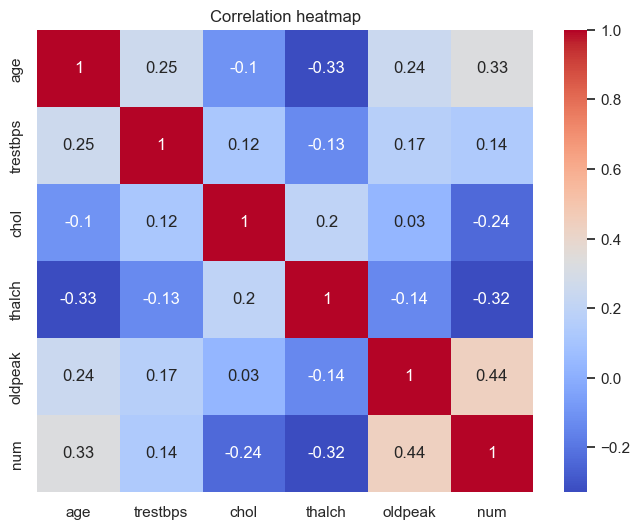

Categorical columns (will be label‑encoded): ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'thal']
Done label‑encoding.

X_train shape: (726, 12)
X_test shape: (182, 12)

=== Baseline Decision Tree Evaluation ===
Accuracy (multi‑class): 0.44505494505494503
Precision (binary 0 vs >0): 0.7478260869565218
Recall (binary 0 vs >0): 0.8431372549019608
F1‑score (binary 0 vs >0): 0.7926267281105991
ROC‑AUC (binary 0 vs >0): 0.7403186274509804

Classification report (multi‑class):
               precision    recall  f1-score   support

           0       0.76      0.64      0.69        80
           1       0.35      0.38      0.36        53
           2       0.20      0.23      0.21        22
           3       0.15      0.19      0.17        21
           4       0.17      0.17      0.17         6

    accuracy                           0.45       182
   macro avg       0.33      0.32      0.32       182
weighted avg       0.48      0.45      0.46       182



C:\Users\Shreyas Mahale\AppData\Local\Temp\ipykernel_10848\1078582236.py:79: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_proc[col].fillna(df_proc[col].median(), inplace=True)
C:\Users\Shreyas Mahale\AppData\Local\Temp\ipykernel_10848\1078582236.py:77: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always

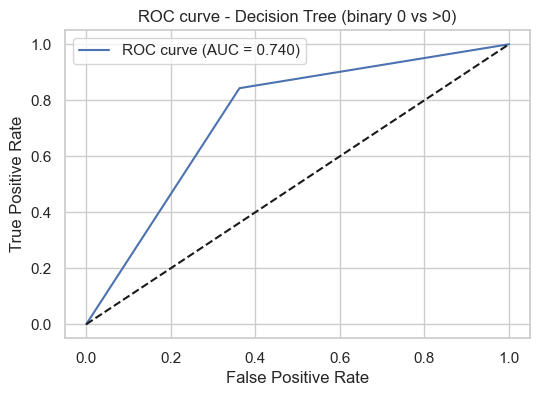


Best params from GridSearchCV: {'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 4, 'min_samples_split': 2}
Best CV accuracy: 0.5661029759093056

=== Tuned Decision Tree Evaluation ===
Accuracy (multi‑class): 0.5054945054945055
Precision (binary 0 vs >0): 0.8414634146341463
Recall (binary 0 vs >0): 0.6764705882352942
F1‑score (binary 0 vs >0): 0.75
ROC‑AUC (binary 0 vs >0): 0.8180759803921568

Classification report (multi‑class):
               precision    recall  f1-score   support

           0       0.67      0.84      0.74        80
           1       0.39      0.40      0.39        53
           2       0.14      0.18      0.16        22
           3       0.00      0.00      0.00        21
           4       0.00      0.00      0.00         6

    accuracy                           0.51       182
   macro avg       0.24      0.28      0.26       182
weighted avg       0.43      0.51      0.46       182



c:\Users\Shreyas Mahale\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Shreyas Mahale\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Shreyas Mahale\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control thi

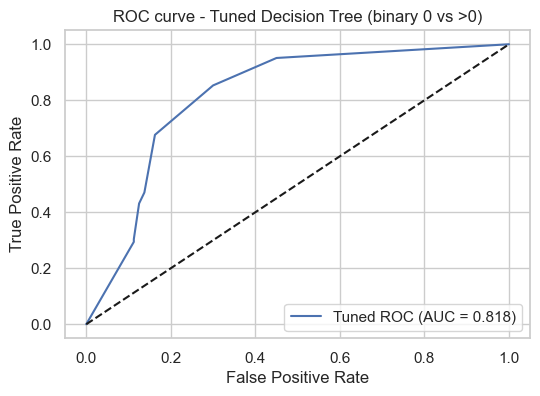


=== Feature importances (tuned tree) ===
     feature  importance
2         cp    0.562547
4       chol    0.176597
0        age    0.152926
8      exang    0.087281
3   trestbps    0.020649
1        sex    0.000000
6    restecg    0.000000
5        fbs    0.000000
7     thalch    0.000000
9    oldpeak    0.000000
10     slope    0.000000
11      thal    0.000000


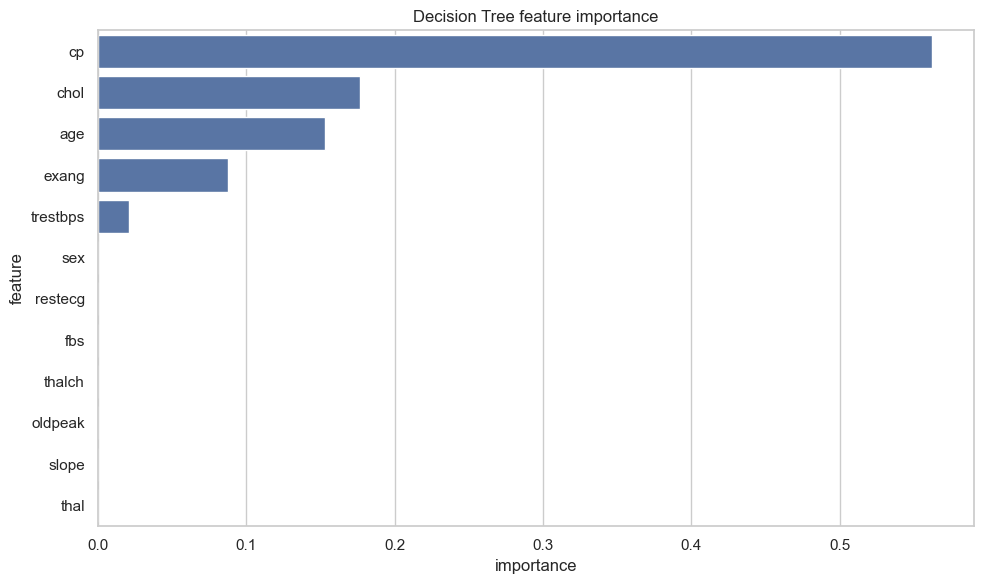

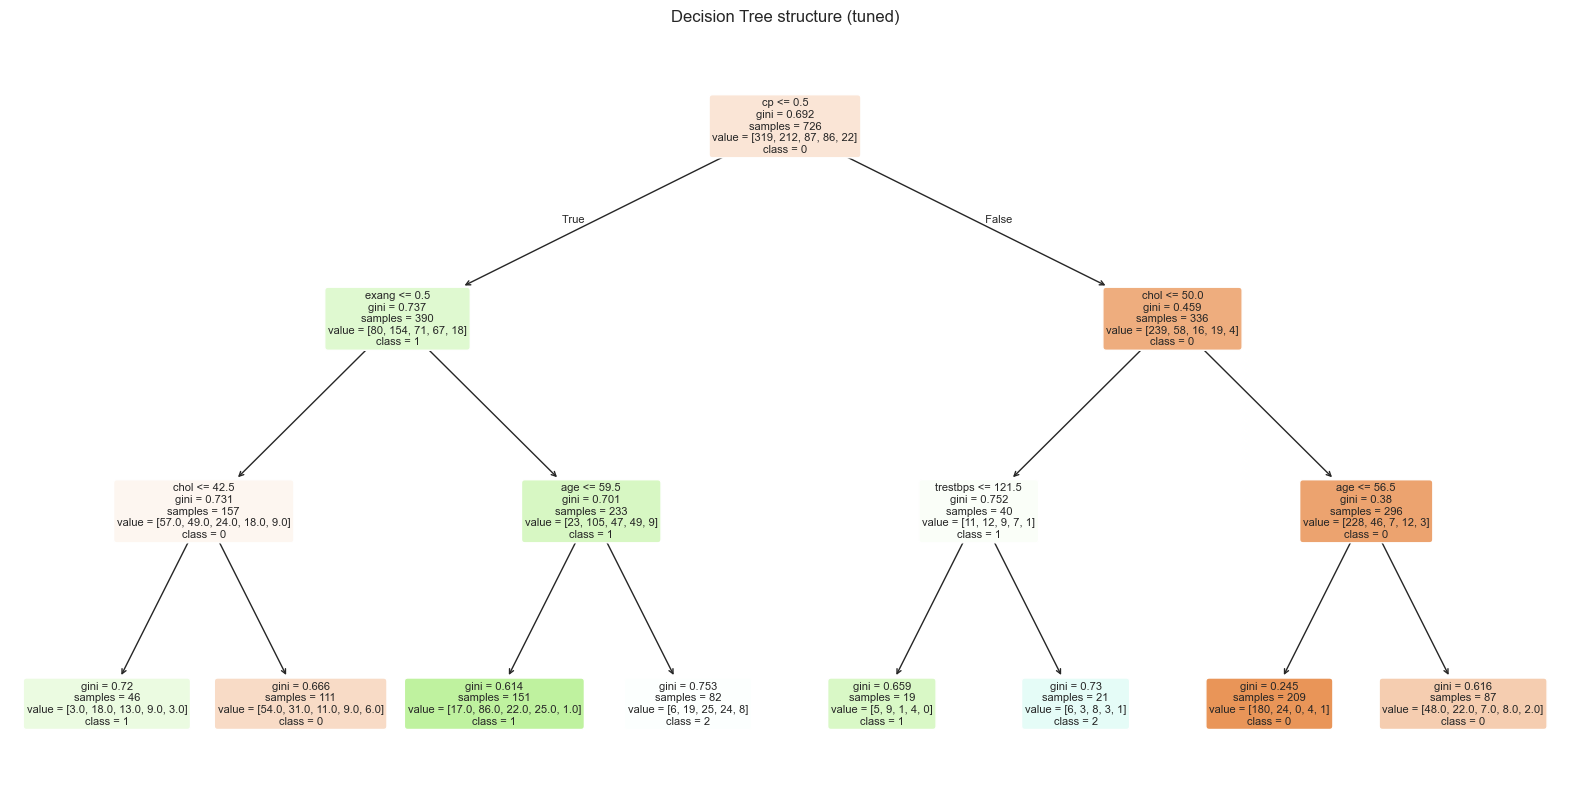

In [2]:
# ===== 1. Imports of the required libraries =====
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, classification_report)

sns.set(style="whitegrid")

# ===== 2. Load data from Excel =====

df = pd.read_excel("C:\\Users\\Shreyas Mahale\\Downloads\\Decision Tree\\Decision Tree\\heart_disease.xlsx", sheet_name=None)

candidate = None
for name, frame in df.items():
    if "num" in frame.columns:
        candidate = frame
        print("Using sheet:", name)
        break

if candidate is None:
    raise ValueError("Could not find a sheet with 'num' column. Please check the file.")

data = candidate.copy()

print("Shape:", data.shape)
print("\nHead:")
print(data.head())
print("\nInfo:")
print(data.info())
print("\nDescribe(include='all'):")
print(data.describe(include="all"))

# ===== 3. Basic EDA =====

# Target distribution (assuming 'num' is 0 = no disease, >0 = disease stage)
plt.figure(figsize=(4,3))
sns.countplot(x="num", data=data)
plt.title("Target distribution (num)")
plt.show()

# Numeric vs target
numeric_cols = data.select_dtypes(include=[np.number]).columns.tolist()
if "num" in numeric_cols:
    numeric_cols.remove("num")

for col in numeric_cols:
    plt.figure(figsize=(4,3))
    sns.histplot(data[col], kde=True)
    plt.title(f"Distribution of {col}")
    plt.show()

    plt.figure(figsize=(4,3))
    sns.boxplot(x="num", y=col, data=data)
    plt.title(f"{col} vs num")
    plt.show()

# Correlation heatmap
if numeric_cols:
    corr_cols = numeric_cols + ["num"]
    plt.figure(figsize=(8,6))
    sns.heatmap(data[corr_cols].corr(), annot=True, cmap="coolwarm")
    plt.title("Correlation heatmap")
    plt.show()

# ===== 4. Feature engineering / preprocessing (FIXED) =====

df_proc = data.copy()

# 4.1 Handle missing values first
for col in df_proc.columns:
    if df_proc[col].dtype == "O":  # object / string
        df_proc[col].fillna(df_proc[col].mode()[0], inplace=True)
    else:
        df_proc[col].fillna(df_proc[col].median(), inplace=True)

# 4.2 Ensure a clean target
target_col = "num"
X = df_proc.drop(columns=[target_col])
y = df_proc[target_col]

# 4.3 Coerce all non‑numeric features to string, and normalize booleans
cat_cols = X.select_dtypes(exclude=[np.number]).columns.tolist()

for col in cat_cols:
    # convert bools to string 'TRUE'/'FALSE' first
    if X[col].dtype == bool:
        X[col] = X[col].map({True: "TRUE", False: "FALSE"})
    # now force everything to string (this removes the ['bool','str'] mix)
    X[col] = X[col].astype(str).str.strip().str.upper()

print("Categorical columns (will be label‑encoded):", cat_cols)

# 4.4 Label encode the categorical columns
from sklearn.preprocessing import LabelEncoder

encoders = {}
for col in cat_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])
    encoders[col] = le

print("Done label‑encoding.")

# ===== 5. Train‑test split =====
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("\nX_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)

# ===== 6. Baseline Decision Tree model =====
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)

y_pred = dt.predict(X_test)

# Below, we convert to binary: 0 vs >0
y_test_bin = (y_test > 0).astype(int)
y_pred_bin = (y_pred > 0).astype(int)
y_proba_bin = dt.predict_proba(X_test)[:, dt.classes_ != 0].max(axis=1)

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test_bin, y_pred_bin)
rec = recall_score(y_test_bin, y_pred_bin)
f1 = f1_score(y_test_bin, y_pred_bin)
roc_auc = roc_auc_score(y_test_bin, y_proba_bin)

print("\n=== Baseline Decision Tree Evaluation ===")
print("Accuracy (multi‑class):", acc)
print("Precision (binary 0 vs >0):", prec)
print("Recall (binary 0 vs >0):", rec)
print("F1‑score (binary 0 vs >0):", f1)
print("ROC‑AUC (binary 0 vs >0):", roc_auc)
print("\nClassification report (multi‑class):\n", classification_report(y_test, y_pred))

fpr, tpr, thresholds = roc_curve(y_test_bin, y_proba_bin)
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.3f})")
plt.plot([0,1], [0,1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curve - Decision Tree (binary 0 vs >0)")
plt.legend()
plt.grid(True)
plt.show()

# ===== 7. Hyperparameter tuning with GridSearchCV =====
param_grid = {
    "max_depth": [3, 4, 5, 6, None],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "criterion": ["gini", "entropy", "log_loss"]
}

grid = GridSearchCV(
    DecisionTreeClassifier(random_state=42),
    param_grid,
    cv=5,
    scoring="accuracy"
)
grid.fit(X_train, y_train)

print("\nBest params from GridSearchCV:", grid.best_params_)
print("Best CV accuracy:", grid.best_score_)

best_dt = grid.best_estimator_

y_pred_tuned = best_dt.predict(X_test)
y_test_bin_tuned = (y_test > 0).astype(int)
y_pred_bin_tuned = (y_pred_tuned > 0).astype(int)
y_proba_bin_tuned = best_dt.predict_proba(X_test)[:, best_dt.classes_ != 0].max(axis=1)

acc_t = accuracy_score(y_test, y_pred_tuned)
prec_t = precision_score(y_test_bin_tuned, y_pred_bin_tuned)
rec_t = recall_score(y_test_bin_tuned, y_pred_bin_tuned)
f1_t = f1_score(y_test_bin_tuned, y_pred_bin_tuned)
roc_auc_t = roc_auc_score(y_test_bin_tuned, y_proba_bin_tuned)

print("\n=== Tuned Decision Tree Evaluation ===")
print("Accuracy (multi‑class):", acc_t)
print("Precision (binary 0 vs >0):", prec_t)
print("Recall (binary 0 vs >0):", rec_t)
print("F1‑score (binary 0 vs >0):", f1_t)
print("ROC‑AUC (binary 0 vs >0):", roc_auc_t)
print("\nClassification report (multi‑class):\n", classification_report(y_test, y_pred_tuned))

fpr_t, tpr_t, thresholds_t = roc_curve(y_test_bin_tuned, y_proba_bin_tuned)
plt.figure(figsize=(6,4))
plt.plot(fpr_t, tpr_t, label=f"Tuned ROC (AUC = {roc_auc_t:.3f})")
plt.plot([0,1], [0,1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curve - Tuned Decision Tree (binary 0 vs >0)")
plt.legend()
plt.grid(True)
plt.show()

# ===== 8. Feature importance & tree visualization =====
importances = best_dt.feature_importances_
feat_imp = pd.DataFrame({"feature": X.columns, "importance": importances})
feat_imp = feat_imp.sort_values(by="importance", ascending=False)
print("\n=== Feature importances (tuned tree) ===")
print(feat_imp)

plt.figure(figsize=(10,6))
sns.barplot(x="importance", y="feature", data=feat_imp)
plt.title("Decision Tree feature importance")
plt.tight_layout()
plt.show()

# Plot the tree (small max_depth recommended for readability)
plt.figure(figsize=(20,10))
plot_tree(
    best_dt,
    feature_names=X.columns,
    class_names=[str(c) for c in sorted(y.unique())],
    filled=True,
    rounded=True,
    fontsize=8
)
plt.title("Decision Tree structure (tuned)")
plt.show()
